In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from chronos import ChronosPipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [35]:
# Step 1: Load the dataset
file_path = '/content/smart_tesla.csv'  # Update if needed
df = pd.read_csv(file_path)
df


,Year,Month,Total Energy Consumed (kWh),Energy Value (Euros),Total Rainfall (mm),Mean Temperature (°C),Total Sunny Days
0,2014,1,618893.0,120862.08,53.1,7.226667,9
1,2014,2,848802.0,122316.49,34.9,8.642857,9
2,2014,3,806574.0,132680.96,92.7,11.310000,15
3,2014,4,325942.0,66829.89,48.5,14.196667,12
4,2014,5,395982.0,79401.83,10.3,19.056667,18
...,...,...,...,...,...,...,...
126,2024,7,349270.0,73434.28,12.9,29.223333,29
127,2024,8,311766.0,65590.17,29.3,28.026667,29
128,2024,9,309851.0,67303.51,47.8,22.053333,20
129,2024,10,369921.0,71200.59,2.6,17.456667,19


In [36]:
# Ensure the target column is properly loaded
target_column = "Total Energy Consumed (kWh)"
time_series_data = df[target_column]

In [37]:
# Step 2: Split the data into train and test sets
train_size = int(len(time_series_data) * 0.9)  # 90% for training
train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

In [33]:
# Step 3: Initialize the Chronos pipeline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipeline = ChronosPipeline.from_pretrained(
    'amazon/chronos-t5-large',
    device_map=device,
    torch_dtype=torch.bfloat16 if device == 'cuda' else torch.float32,
)

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [38]:
# Step 4: Generate predictions
test_length = len(test_data)  # Correctly set to the size of the test data
context = torch.tensor(train_data.values, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Predict with the correct test length
forecast = pipeline.predict(context, prediction_length=test_length)

# Slice and flatten to match the test data length
predicted_values = forecast[0].numpy().flatten()[:test_length]

# Ensure true_values matches the length of predicted_values
true_values = np.array(test_data[:len(predicted_values)])

In [39]:
# Step 5: Evaluate the model's accuracy
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

print(f"Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 50004.19
Root Mean Squared Error (RMSE): 68632.69
Mean Absolute Percentage Error (MAPE): 12.00%


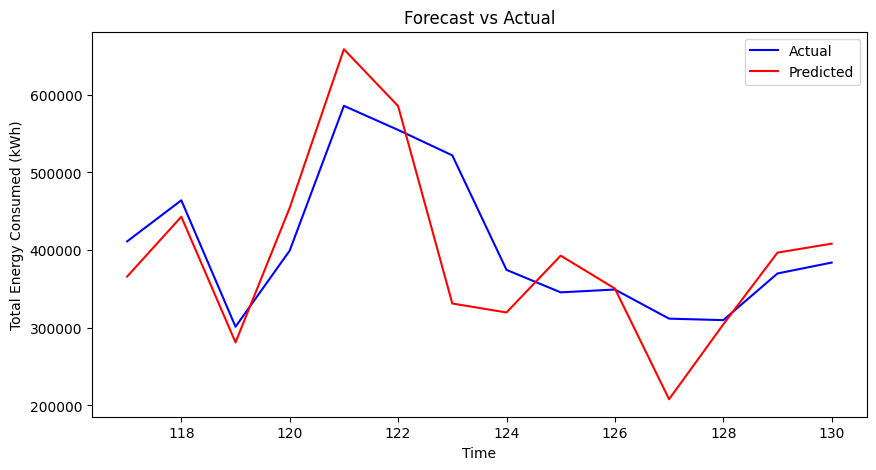

In [40]:
# Step 6: Visualize the forecast vs actual
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_data), len(time_series_data)), true_values, label='Actual', color='blue')
plt.plot(range(len(train_data), len(time_series_data)), predicted_values, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Total Energy Consumed (kWh)')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

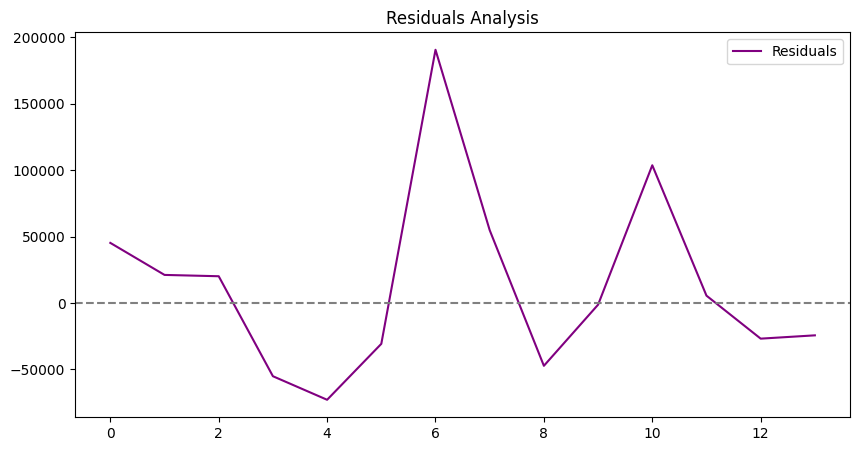

In [41]:
# Step 7: Residual analysis (optional)
residuals = true_values - predicted_values
plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals Analysis')
plt.legend()
plt.show()

In [42]:
# Step 8: Benchmark against a naive forecast
naive_forecast = true_values[:-1]  # Use previous value as the forecast
naive_mae = mean_absolute_error(true_values[1:], naive_forecast)
naive_mape = np.mean(np.abs((true_values[1:] - naive_forecast) / true_values[1:])) * 100
print(f"Naive Forecast MAE: {naive_mae:.2f}")
print(f"Naive Forecast MAPE: {naive_mape:.2f}")

Naive Forecast MAE: 65964.62
Naive Forecast MAPE: 16.54


#**Random Forest**

In [15]:
from sklearn.ensemble import RandomForestRegressor


In [16]:
# Step 1: Load the dataset
file_path = '/content/smart_tesla.csv'  # Update if needed
df = pd.read_csv(file_path)

# Ensure the target column is properly loaded
target_column = "Total Energy Consumed (kWh)"
time_series_data = df[target_column]


In [17]:
# Step 2: Create lag features
def create_lag_features(data, lags=5):
    lagged_data = pd.DataFrame({'y': data})
    for lag in range(1, lags + 1):
        lagged_data[f'lag_{lag}'] = lagged_data['y'].shift(lag)
    lagged_data.dropna(inplace=True)
    return lagged_data

lags = 5  # Number of past time steps to use as features
lagged_data = create_lag_features(time_series_data, lags)

# Split into features (X) and target (y)
X = lagged_data.drop(columns=['y'])
y = lagged_data['y']

In [18]:
# Step 3: Split the data into training and test sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [19]:
# Step 4: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [20]:
# Step 5: Make predictions
y_pred = rf_model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Random Forest Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Random Forest Evaluation Metrics:
Mean Absolute Error (MAE): 86570.54
Root Mean Squared Error (RMSE): 109932.23
Mean Absolute Percentage Error (MAPE): 22.86%


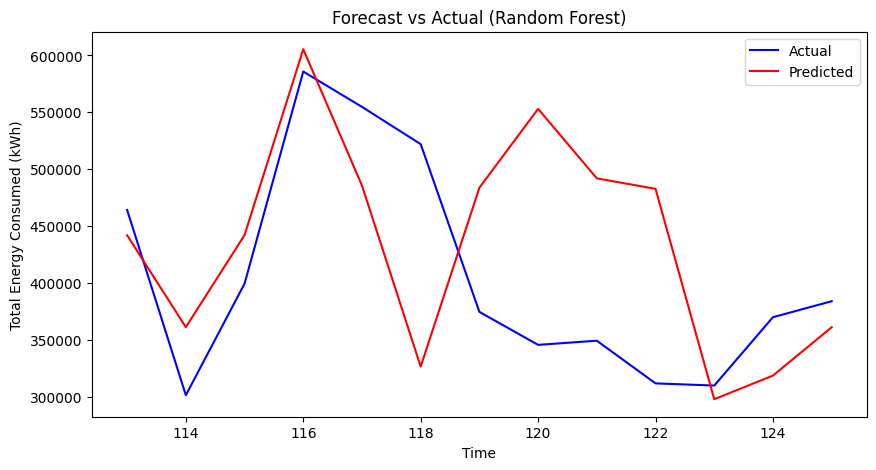

In [21]:
# Step 7: Visualize the forecast vs actual
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual', color='blue')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Total Energy Consumed (kWh)')
plt.title('Forecast vs Actual (Random Forest)')
plt.legend()
plt.show()

#**XGB**

In [22]:
from xgboost import XGBRegressor

# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"Random Forest Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Random Forest Evaluation Metrics:
Mean Absolute Error (MAE): 86920.82
Root Mean Squared Error (RMSE): 104342.55
Mean Absolute Percentage Error (MAPE): 22.43%


#**Random Forest & XGB**


Performing XGBoost Cross-validation...

Performing Random Forest Cross-validation...

XGBoost Cross-validation Results:
MAPE: 14.53
RMSE: 78535.20
R2: 0.75
Bias: 26396.39

Random Forest Cross-validation Results:
MAPE: 14.57
RMSE: 76338.33
R2: 0.76
Bias: 24152.00

Plotting Feature Importance for XGBoost...


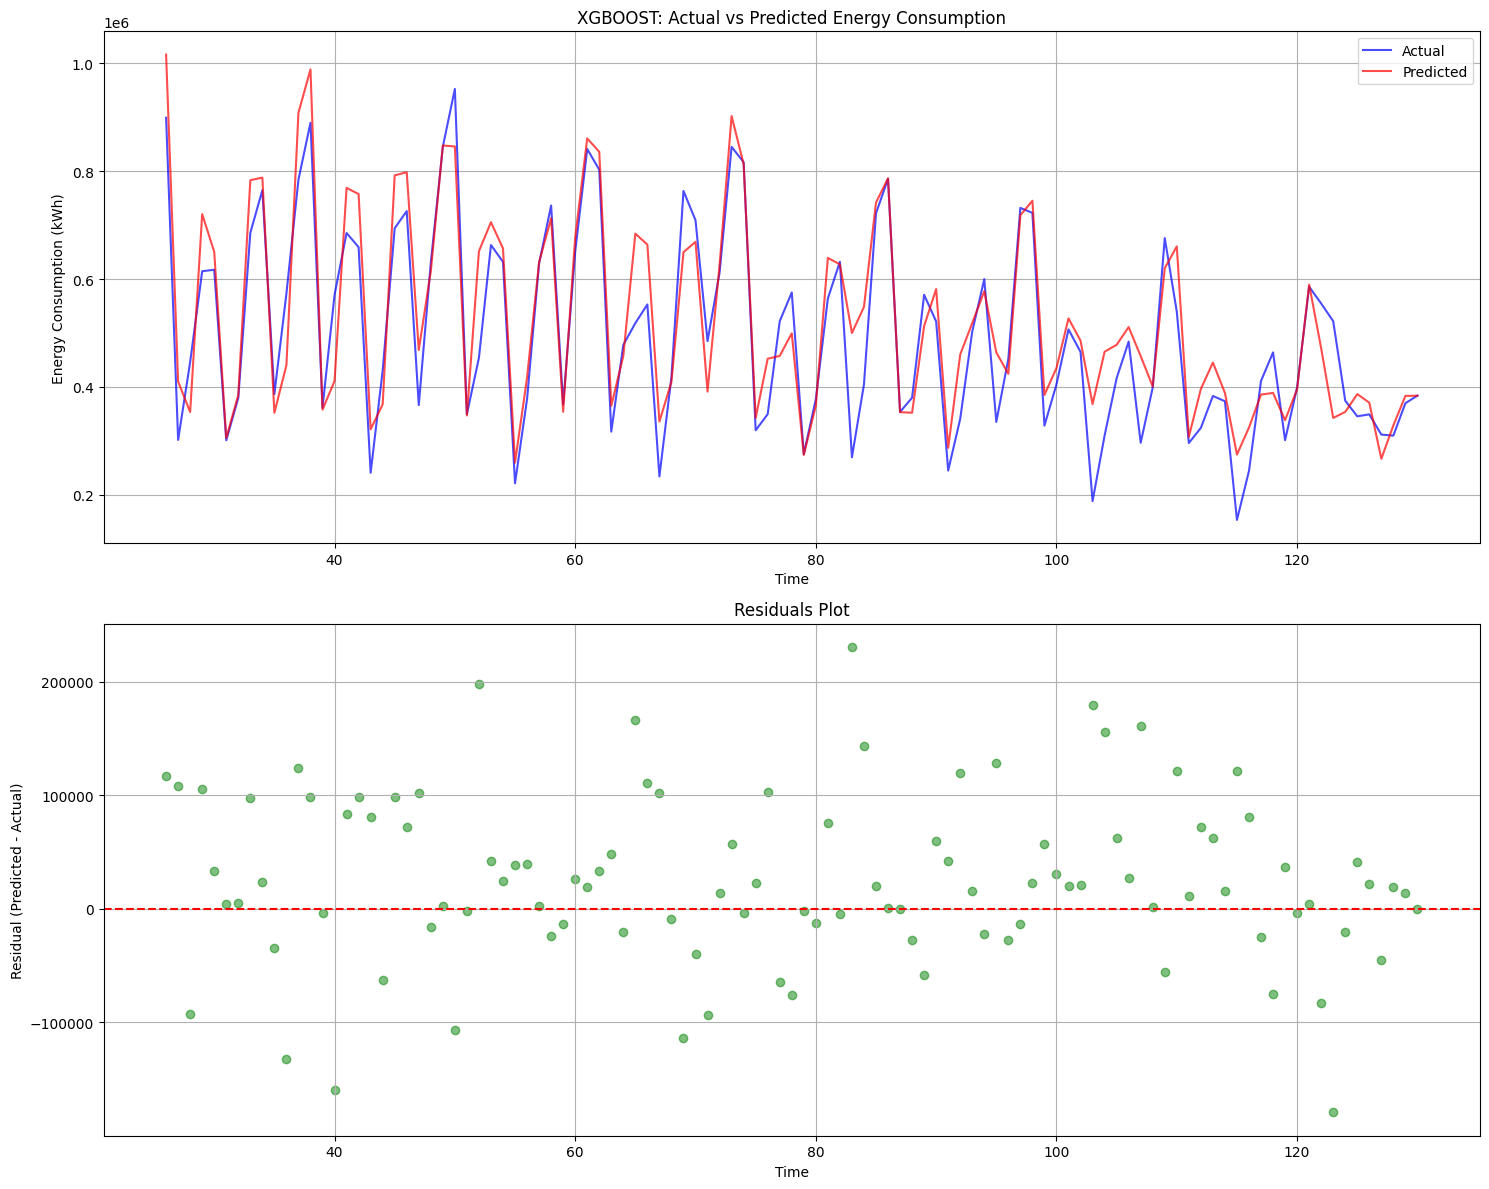

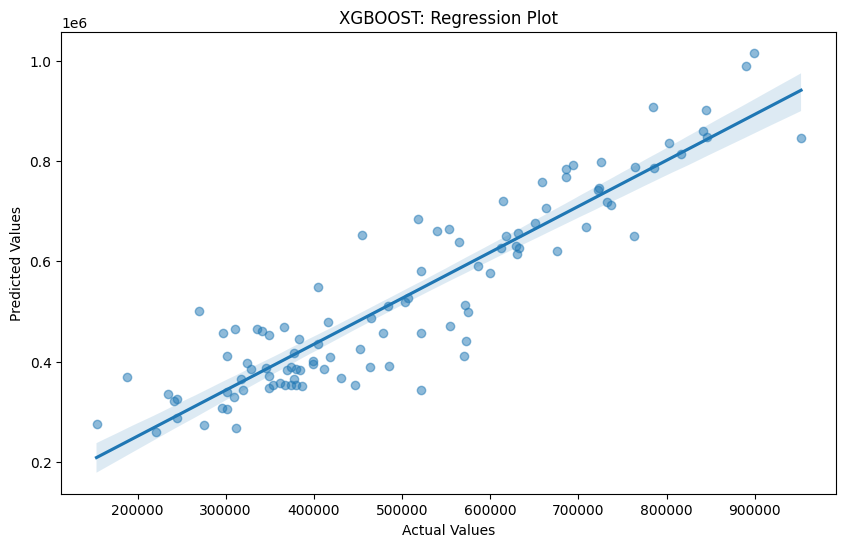

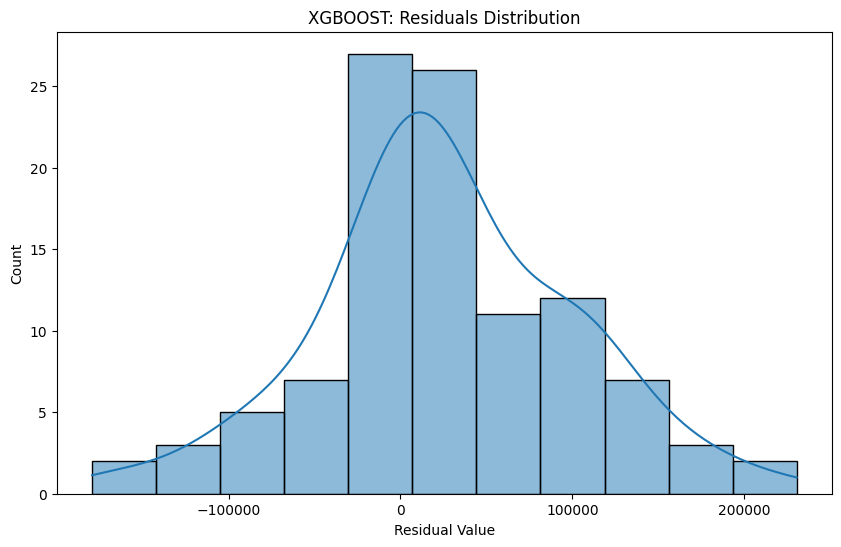

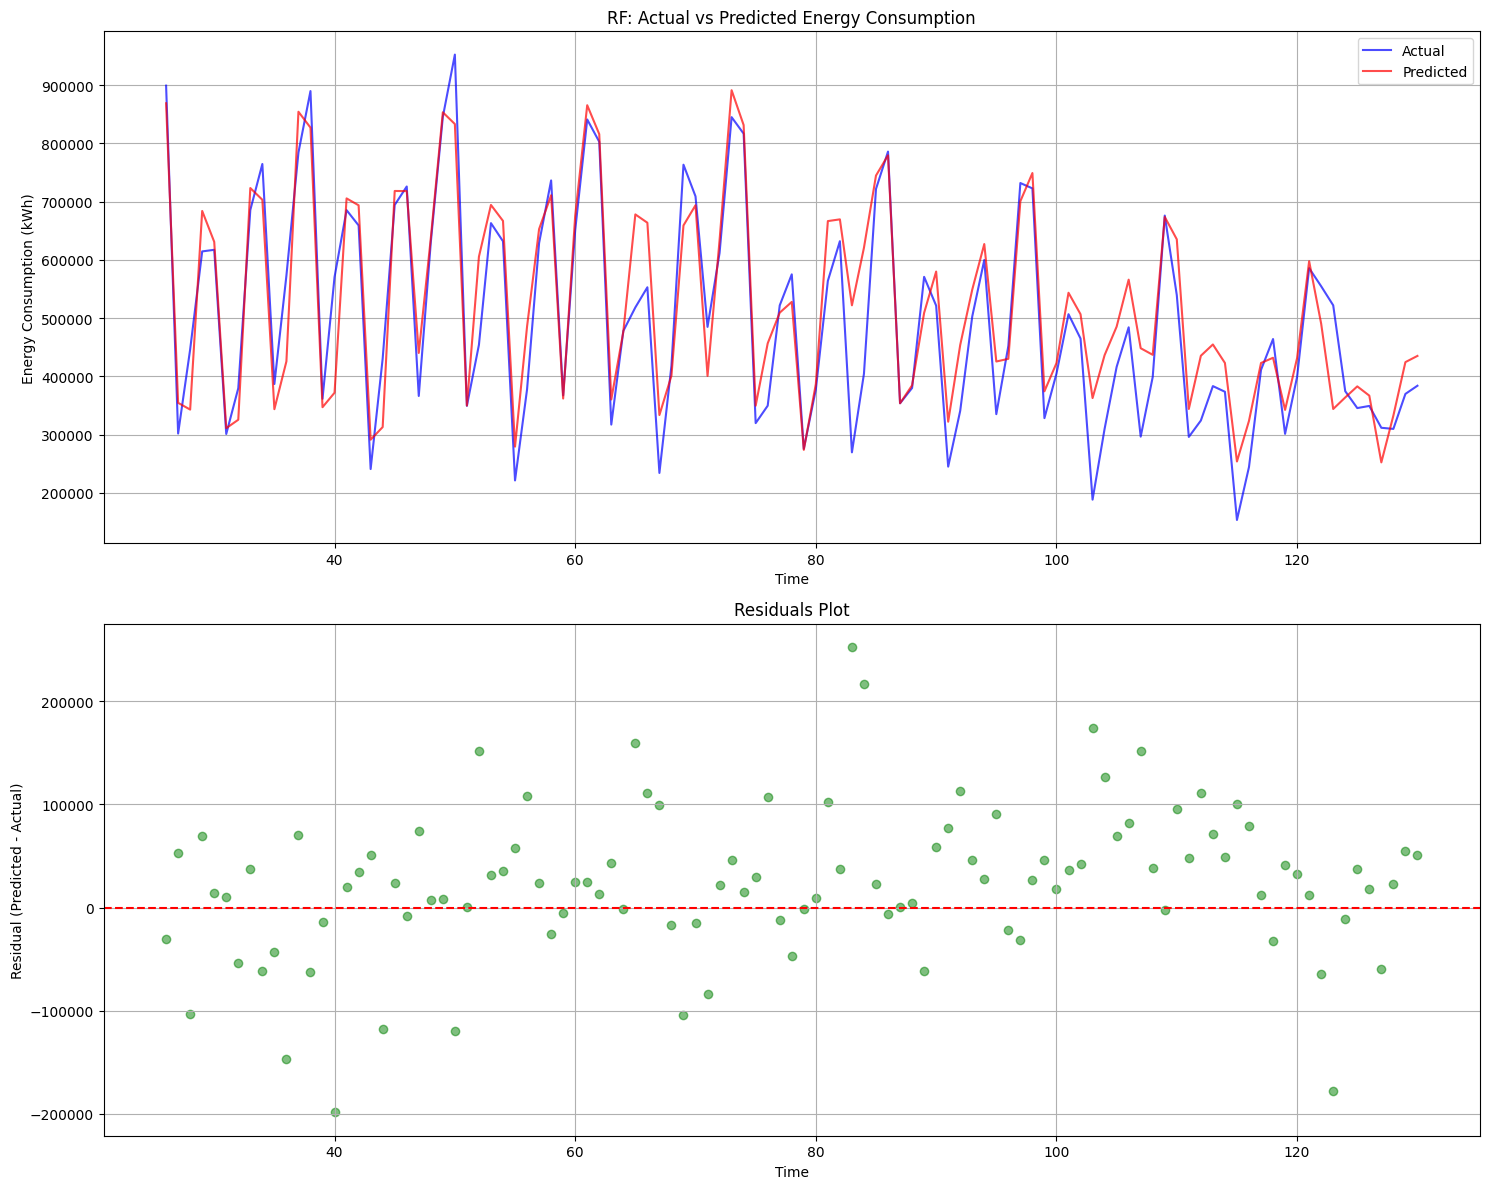

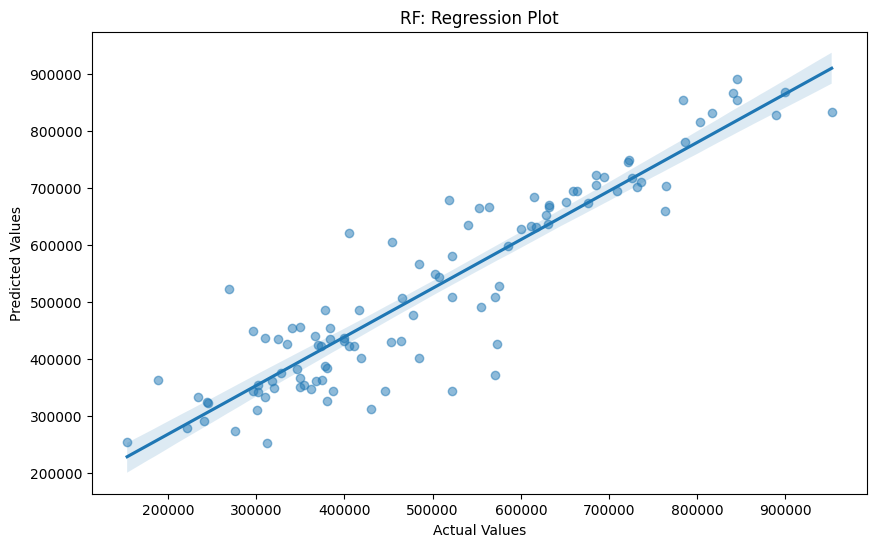

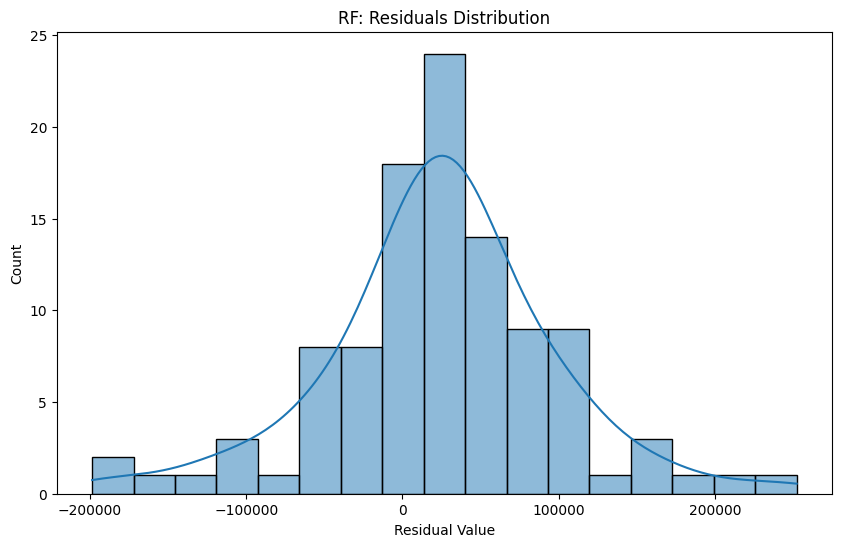

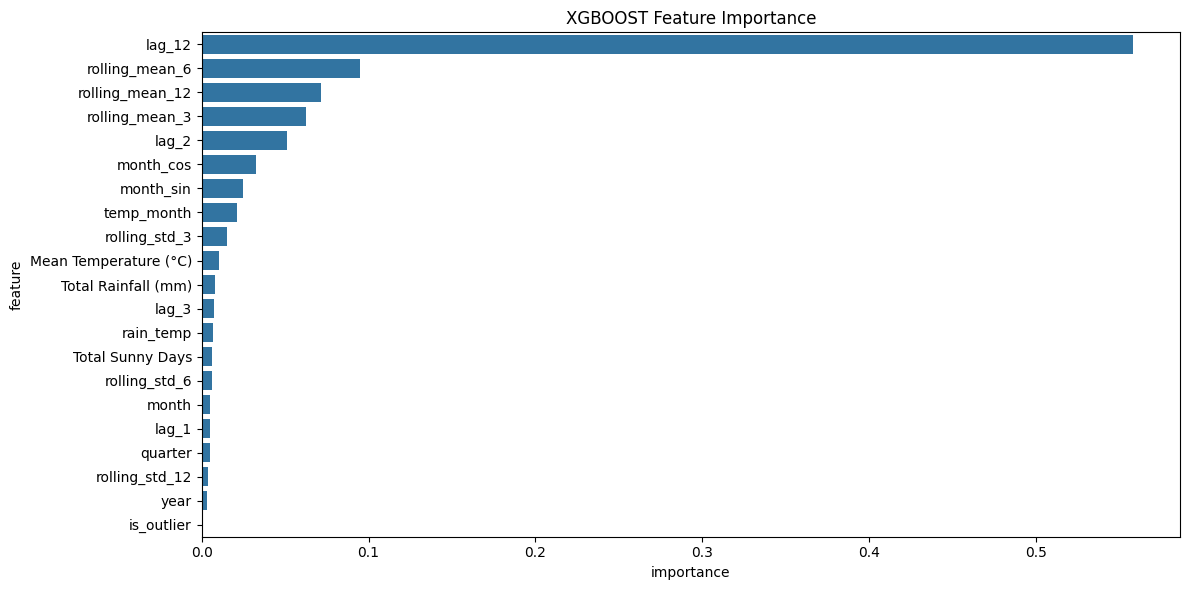

In [31]:
# Best so far - C

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

class ImprovedEnergyForecaster:
    def __init__(self, model_type='xgboost'):
        self.model_type = model_type
        self.model = None
        self.scaler = StandardScaler()

    def create_features(self, df):
        """Create enhanced time series features."""
        df = df.copy()

        # Basic date features
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['quarter'] = df['date'].dt.quarter

        # Add seasonality features
        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

        # Enhanced lag features
        df['lag_1'] = df.groupby(['year'])['Total Energy Consumed (kWh)'].shift(1)
        df['lag_2'] = df.groupby(['year'])['Total Energy Consumed (kWh)'].shift(2)
        df['lag_3'] = df.groupby(['year'])['Total Energy Consumed (kWh)'].shift(3)
        df['lag_12'] = df['Total Energy Consumed (kWh)'].shift(12)  # Year-over-year lag

        # Create rolling features with different windows
        windows = [3, 6, 12]
        for window in windows:
            df[f'rolling_mean_{window}'] = df.groupby(['year'])['Total Energy Consumed (kWh)'].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean())
            df[f'rolling_std_{window}'] = df.groupby(['year'])['Total Energy Consumed (kWh)'].transform(
                lambda x: x.rolling(window=window, min_periods=1).std())

        # Interaction features
        df['temp_month'] = df['Mean Temperature (°C)'] * df['month']
        df['rain_temp'] = df['Total Rainfall (mm)'] * df['Mean Temperature (°C)']

        # Handle missing values more sophisticatedly
        self._handle_missing_values(df)

        # Add outlier detection
        df['is_outlier'] = self._detect_outliers(df['Total Energy Consumed (kWh)'])

        return df

    def _detect_outliers(self, series, threshold=3):
        """Detect outliers using z-score method."""
        z_scores = np.abs((series - series.mean()) / series.std())
        return z_scores > threshold

    def _handle_missing_values(self, df):
        """Handle missing values with more sophisticated methods."""
        # Handle lag features
        lag_cols = [col for col in df.columns if 'lag' in col]
        for col in lag_cols:
            # First try to fill with same month from previous year
            df[col] = df.groupby('month')[col].transform(
                lambda x: x.fillna(x.mean()))
            # If still missing, use overall mean
            df[col] = df[col].fillna(df[col].mean())

        # Handle rolling features
        rolling_cols = [col for col in df.columns if 'rolling' in col]
        for col in rolling_cols:
            df[col] = df[col].bfill().ffill()

    def prepare_data(self, df):
        """Prepare features and target variables."""
        df = self.create_features(df)

        feature_columns = [
            'month', 'quarter', 'year', 'month_sin', 'month_cos',
            'Mean Temperature (°C)', 'Total Rainfall (mm)', 'Total Sunny Days',
            'lag_1', 'lag_2', 'lag_3', 'lag_12',
            'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12',
            'rolling_std_3', 'rolling_std_6', 'rolling_std_12',
            'temp_month', 'rain_temp', 'is_outlier'
        ]

        X = df[feature_columns]
        y = df['Total Energy Consumed (kWh)']

        return X, y

    def initialize_model(self):
        """Initialize model with improved parameters."""
        if self.model_type == 'xgboost':
            self.model = XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )
        else:  # random forest
            self.model = RandomForestRegressor(
                n_estimators=200,
                max_depth=12,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            )

    def evaluate(self, actual, predicted):
        """Calculate multiple evaluation metrics including bias."""
        bias = np.mean(predicted - actual)  # Average prediction error (bias)
        return {
            'MAPE': mean_absolute_percentage_error(actual, predicted) * 100,
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'R2': r2_score(actual, predicted),
            'Bias': bias
        }

    def plot_forecast_vs_actual(self, test_data, actual, predicted, title=None):
        """Plot forecasted vs actual values and residuals."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # Plot 1: Actual vs Predicted
        ax1.plot(test_data.index, actual, label='Actual', color='blue', alpha=0.7)
        ax1.plot(test_data.index, predicted, label='Predicted', color='red', alpha=0.7)
        ax1.set_title(f'{title if title else self.model_type.upper()}: Actual vs Predicted Energy Consumption')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Energy Consumption (kWh)')
        ax1.legend()
        ax1.grid(True)

        # Plot 2: Residuals
        residuals = predicted - actual
        ax2.scatter(test_data.index, residuals, alpha=0.5, color='green')
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_title('Residuals Plot')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Residual (Predicted - Actual)')
        ax2.grid(True)

        plt.tight_layout()
        return fig

    def plot_feature_importance(self, X):
        """Plot feature importance for the model."""
        if hasattr(self.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(12, 6))
            sns.barplot(data=importance_df, x='importance', y='feature')
            plt.title(f'{self.model_type.upper()} Feature Importance')
            plt.tight_layout()
            return plt.gcf()
        else:
            raise AttributeError("The selected model does not support feature importance.")

    def analyze_performance(self, test_data, actual, predicted):
        """Analyze model performance with additional visualizations."""
        # Create regression plot
        plt.figure(figsize=(10, 6))
        sns.regplot(x=actual, y=predicted, scatter_kws={'alpha':0.5})
        plt.title(f'{self.model_type.upper()}: Regression Plot')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        regression_fig = plt.gcf()

        # Create residuals distribution plot
        residuals = predicted - actual
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title(f'{self.model_type.upper()}: Residuals Distribution')
        plt.xlabel('Residual Value')
        plt.ylabel('Count')
        residuals_fig = plt.gcf()

        return regression_fig, residuals_fig

    def cross_validate(self, data, n_splits=5):
        """Perform time series cross-validation with visualization."""
        tscv = TimeSeriesSplit(n_splits=n_splits)
        X, y = self.prepare_data(data)

        metrics = {
            'MAPE': [],
            'RMSE': [],
            'R2': [],
            'Bias': []
        }

        # Store predictions for later visualization
        all_predictions = []
        all_actuals = []
        all_indices = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            if self.model is None:
                self.initialize_model()

            self.model.fit(X_train_scaled, y_train)
            predictions = self.model.predict(X_test_scaled)

            fold_metrics = self.evaluate(y_test, predictions)
            for metric, value in fold_metrics.items():
                metrics[metric].append(value)

            all_predictions.extend(predictions)
            all_actuals.extend(y_test)
            all_indices.extend(test_idx)

        test_df = pd.DataFrame({
            'actual': all_actuals,
            'predicted': all_predictions
        }, index=[data.index[i] for i in all_indices])

        forecast_plot = self.plot_forecast_vs_actual(test_df, test_df['actual'], test_df['predicted'])
        regression_plot, residuals_plot = self.analyze_performance(test_df, test_df['actual'], test_df['predicted'])

        return {
            'metrics': {metric: np.mean(values) for metric, values in metrics.items()},
            'plots': {
                'forecast': forecast_plot,
                'regression': regression_plot,
                'residuals': residuals_plot
            }
        }

# Main function
if __name__ == "__main__":
    df = pd.read_csv('/content/smart_tesla.csv')
    df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
    df = df.sort_values('date').reset_index(drop=True)

    xgb_forecaster = ImprovedEnergyForecaster(model_type='xgboost')
    rf_forecaster = ImprovedEnergyForecaster(model_type='rf')

    print("\nPerforming XGBoost Cross-validation...")
    xgb_results = xgb_forecaster.cross_validate(df)

    print("\nPerforming Random Forest Cross-validation...")
    rf_results = rf_forecaster.cross_validate(df)

    print("\nXGBoost Cross-validation Results:")
    for metric, value in xgb_results['metrics'].items():
        print(f"{metric}: {value:.2f}")

    print("\nRandom Forest Cross-validation Results:")
    for metric, value in rf_results['metrics'].items():
        print(f"{metric}: {value:.2f}")

    # Plot feature importance for XGBoost
    print("\nPlotting Feature Importance for XGBoost...")
    feature_importance_plot = xgb_forecaster.plot_feature_importance(xgb_forecaster.prepare_data(df)[0])
    plt.show()

    plt.show()


#**RF & XGB Ensemble**

Training set shape: (120, 7)
Hold-out set shape: (11, 7)

===== HOLD-OUT RESULTS (2024) =====
MAPE: 0.71%
RMSE: 3405.51
R^2:  1.00


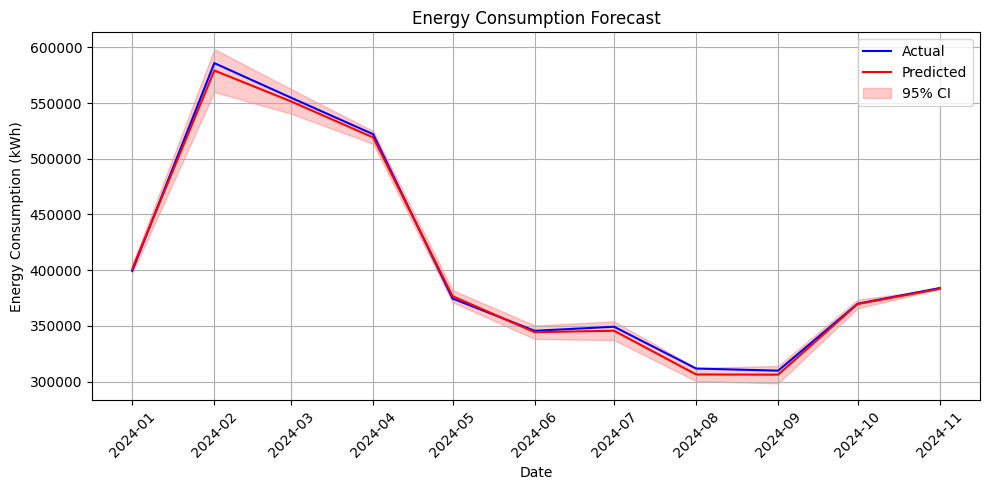

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

##############################################################################
# 1) A custom FeatureEngineer without tags
##############################################################################
class FeatureEngineer:
    def __init__(self, max_lag=12):
        self.max_lag = max_lag
        self.month_lag_means_ = {}

    # Required so that Pipeline or RandomizedSearchCV can discover parameters
    def get_params(self, deep=True):
        return {"max_lag": self.max_lag}

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def fit(self, X, y=None):
        """Compute month-based mean for each lag/ewm column using training data."""
        df = X.copy()
        df = self._create_features(df)
        lag_cols = [c for c in df.columns if 'lag_' in c or 'ewm_' in c or 'volatility_' in c]
        self.month_lag_means_ = (
            df.groupby('Month')[lag_cols]
              .mean(numeric_only=True)
              .to_dict('index')
        )
        return self

    def transform(self, X, y=None):
        """Apply feature engineering and fill missing lag values."""
        df = X.copy()
        df = self._create_features(df)

        # Fill missing lag columns
        lag_cols = [c for c in df.columns if 'lag_' in c or 'ewm_' in c or 'volatility_' in c]
        for idx, row in df.iterrows():
            m = row['Month']
            for c in lag_cols:
                if pd.isna(row[c]) and (m in self.month_lag_means_):
                    if c in self.month_lag_means_[m]:
                        df.at[idx, c] = self.month_lag_means_[m][c]

        # Fill remaining NAs with column means
        df.fillna(df.mean(numeric_only=True), inplace=True)

        # Drop any non‐numeric columns you don’t want scaled, e.g. Date
        if 'Date' in df.columns:
            df.drop(columns=['Date'], inplace=True)

        # If the target is still in df and you don't want it as a feature, drop it:
        # if 'Total Energy Consumed (kWh)' in df.columns:
        #     df.drop(columns='Total Energy Consumed (kWh)', inplace=True)

        return df

    def _create_features(self, df):
        df['Date'] = pd.to_datetime(df[['Year','Month']].assign(DAY=1))
        df.sort_values(by=['Year','Month'], inplace=True)

        # Example time-based features
        df['quarter'] = df['Date'].dt.quarter

        # Create lags, EWM
        for i in [1, 2, 3, 6, 12]:
            if i <= self.max_lag:
                df[f'lag_{i}'] = df['Total Energy Consumed (kWh)'].shift(i)
                df[f'ewm_{i}'] = df['Total Energy Consumed (kWh)'].ewm(span=i).mean()

        # Rolling volatility
        for window in [3, 6, 12]:
            if window <= self.max_lag:
                rolling_std = df['Total Energy Consumed (kWh)'].rolling(window=window, min_periods=1).std()
                rolling_mean = df['Total Energy Consumed (kWh)'].rolling(window=window, min_periods=1).mean()
                df[f'volatility_{window}'] = rolling_std / rolling_mean

        # Additional features
        df['temp_squared'] = df['Mean Temperature (°C)'] ** 2
        df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

        # Optionally handle external features like rainfall or sunny days
        if 'Total Rainfall (mm)' not in df.columns:
            df['Total Rainfall (mm)'] = 0.0
        if 'Total Sunny Days' not in df.columns:
            df['Total Sunny Days'] = 0

        return df

##############################################################################
# 2) A custom ensemble regressor without tags
##############################################################################
class EnsembleEnergyForecaster:
    def __init__(self, do_grid_search=True, random_state=42):
        self.do_grid_search = do_grid_search
        self.random_state = random_state
        self.xgb_model_ = None
        self.rf_model_ = None
        self.scaler_ = StandardScaler()
        self.fitted_ = False
        self.alpha_xgb_ = 0.5
        self.alpha_rf_ = 0.5

    # For hyperparameter search
    def get_params(self, deep=True):
        return {"do_grid_search": self.do_grid_search, "random_state": self.random_state}

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def fit(self, X, y):
        X_scaled = self.scaler_.fit_transform(X)
        tscv = TimeSeriesSplit(n_splits=3)

        if self.do_grid_search:
            # Basic param distributions
            param_dist_xgb = {
                'n_estimators': [100, 200],
                'max_depth': [3, 6],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0],
            }
            xgb_search = RandomizedSearchCV(
                XGBRegressor(random_state=self.random_state),
                param_distributions=param_dist_xgb,
                n_iter=5,
                cv=tscv,
                scoring='neg_mean_absolute_percentage_error',
                n_jobs=-1,
                random_state=self.random_state
            )
            xgb_search.fit(X_scaled, y)
            self.xgb_model_ = xgb_search.best_estimator_

            param_dist_rf = {
                'n_estimators': [100, 200],
                'max_depth': [6, 12],
                'max_features': ['sqrt', 0.75],
            }
            rf_search = RandomizedSearchCV(
                RandomForestRegressor(random_state=self.random_state),
                param_distributions=param_dist_rf,
                n_iter=5,
                cv=tscv,
                scoring='neg_mean_absolute_percentage_error',
                n_jobs=-1,
                random_state=self.random_state
            )
            rf_search.fit(X_scaled, y)
            self.rf_model_ = rf_search.best_estimator_

        else:
            self.xgb_model_ = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=self.random_state)
            self.rf_model_  = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=self.random_state)
            self.xgb_model_.fit(X_scaled, y)
            self.rf_model_.fit(X_scaled, y)

        # Learn ensemble weights on a small holdout from the training set
        val_size = int(0.1 * len(X))
        if val_size > 0:
            X_train_small, X_val = X_scaled[:-val_size], X_scaled[-val_size:]
            y_train_small, y_val = y[:-val_size], y[-val_size:]
            self.xgb_model_.fit(X_train_small, y_train_small)
            self.rf_model_.fit(X_train_small, y_train_small)

            pred_xgb = self.xgb_model_.predict(X_val)
            pred_rf  = self.rf_model_.predict(X_val)

            # Simple grid over alpha
            best_alpha = 0.5
            best_mape = float('inf')
            for alpha in np.linspace(0, 1, 21):
                combo = alpha * pred_xgb + (1 - alpha) * pred_rf
                cur_mape = mean_absolute_percentage_error(y_val, combo)
                if cur_mape < best_mape:
                    best_mape = cur_mape
                    best_alpha = alpha

            self.alpha_xgb_ = best_alpha
            self.alpha_rf_  = 1 - best_alpha

        # Finally refit on the full set
        self.xgb_model_.fit(X_scaled, y)
        self.rf_model_.fit(X_scaled, y)

        self.fitted_ = True
        return self

    def predict(self, X, return_ci=True):
        if not self.fitted_:
            raise RuntimeError("Model not fitted yet. Call fit() first.")
        X_scaled = self.scaler_.transform(X)
        pred_xgb = self.xgb_model_.predict(X_scaled)
        pred_rf  = self.rf_model_.predict(X_scaled)
        # Weighted average
        predictions = self.alpha_xgb_ * pred_xgb + self.alpha_rf_ * pred_rf
        if return_ci:
            # Simple approximate interval from ensemble stdev
            all_preds = np.vstack([pred_xgb, pred_rf])
            std_dev = np.std(all_preds, axis=0)
            ci_lower = predictions - 1.96 * std_dev
            ci_upper = predictions + 1.96 * std_dev
            return predictions, ci_lower, ci_upper
        return predictions

    def plot_results(self, dates, y_true, y_pred, ci_lower=None, ci_upper=None):
        plt.figure(figsize=(10,5))
        plt.plot(dates, y_true, label='Actual', color='blue')
        plt.plot(dates, y_pred, label='Predicted', color='red')
        if ci_lower is not None and ci_upper is not None:
            plt.fill_between(dates, ci_lower, ci_upper, color='red', alpha=0.2, label='95% CI')
        plt.title('Energy Consumption Forecast')
        plt.xlabel('Date')
        plt.ylabel('Energy Consumption (kWh)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

##############################################################################
# 3) Main Execution
##############################################################################
if __name__ == "__main__":
    # Load data
    df_raw = pd.read_csv("/content/smart_tesla.csv")
    df_raw.sort_values(by=["Year","Month"], inplace=True)
    df_raw.reset_index(drop=True, inplace=True)

    # Example holdout: all months in 2024
    holdout_mask = (df_raw['Year'] == 2024)
    df_train = df_raw.loc[~holdout_mask].copy()
    df_holdout = df_raw.loc[holdout_mask].copy()

    print(f"Training set shape: {df_train.shape}")
    print(f"Hold-out set shape: {df_holdout.shape}")

    # Separate out y
    y_train = df_train['Total Energy Consumed (kWh)']
    y_holdout = df_holdout['Total Energy Consumed (kWh)']

    # Make pipeline
    pipeline = Pipeline([
        ('features', FeatureEngineer(max_lag=12)),
        ('model', EnsembleEnergyForecaster(do_grid_search=False, random_state=42))
    ])

    # Fit pipeline
    pipeline.fit(df_train, y_train)

    # Predict on hold-out
    preds, ci_lo, ci_hi = pipeline.predict(df_holdout, return_ci=True)

    # Evaluate
    mape = mean_absolute_percentage_error(y_holdout, preds)*100
    rmse = np.sqrt(mean_squared_error(y_holdout, preds))
    r2   = r2_score(y_holdout, preds)
    print("\n===== HOLD-OUT RESULTS (2024) =====")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2:  {r2:.2f}")

    # Plot
    dates_holdout = pd.to_datetime(df_holdout[['Year','Month']].assign(DAY=1))
    pipeline.named_steps['model'].plot_results(dates_holdout, y_holdout, preds, ci_lo, ci_hi)
